In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from xgboost import XGBClassifier

from automated_scoring.config import cfg
from automated_scoring.io import load_dataset, save_dataset
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.classification.predict import predict_dataset, k_fold_predict
from automated_scoring.classification.optimize import optimize_smoothing, optimize_decision_thresholds
from automated_scoring.classification.visualization import (
    plot_confusion_matrix,
    plot_classification_timeline,
)
from automated_scoring.utils import ensure_generator

from scipy.signal import medfilt

cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = (
    "keypoints",
    "timestamps",
)

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
dataset_train = load_dataset("mice_train", directory="datasets", target="dyads")
dataset_test = load_dataset("mice_test", directory="datasets", target="dyads")

Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.
Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [4]:
extractor = DataFrameFeatureExtractor(cache_directory="feature_cache_mice").read_yaml("config_file.yaml")

In [6]:
def subsample_train(
    dataset,
    extractor,
    random_state=None,
    exclude=None,
):
    X_subsample_even, y_subsample_even = dataset.subsample(
        extractor,
        0.1,
        categories=("none", "investigation"),
        random_state=random_state,
        show_progress=False,
        exclude=exclude,
    )
    X_subsample_all, y_subsample_all = dataset.subsample(
        extractor,
        1.0,
        try_even_subsampling=False,
        categories=("attack", "mount"),
        random_state=random_state,
        show_progress=False,
        exclude=exclude,
    )
    return (
        pd.concat([X_subsample_even, X_subsample_all]),
        np.concatenate([y_subsample_even, y_subsample_all]),
    )

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/44 [00:00<?, ?it/s]

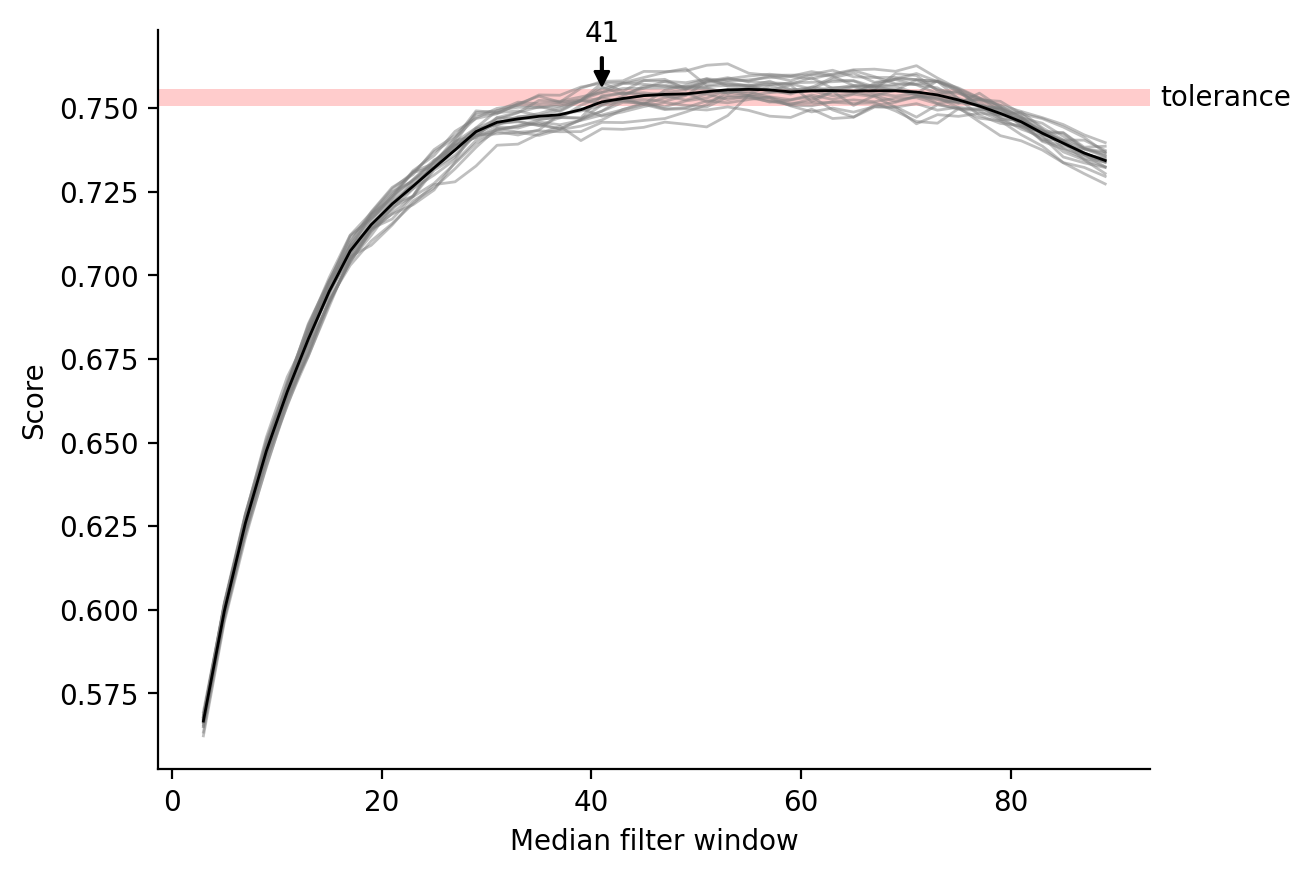

{'median_filter_window': 41.0}

In [7]:
best_parameters = optimize_smoothing(
    dataset_train,
    extractor,
    XGBClassifier,
    lambda probabilities, parameters: medfilt(probabilities, parameters["median_filter_window"]),
    smoothing_parameters_grid={"median_filter_window": np.arange(3, 91, 2)},
    num_iterations=20,
    show_progress=True,
    k=5,
    exclude=[("intruder", "resident")],
    sampling_func=subsample_train,
    show_k_fold_progress=False,
    tolerance=0.005,
    random_state=ensure_generator(1),
)

best_parameters

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

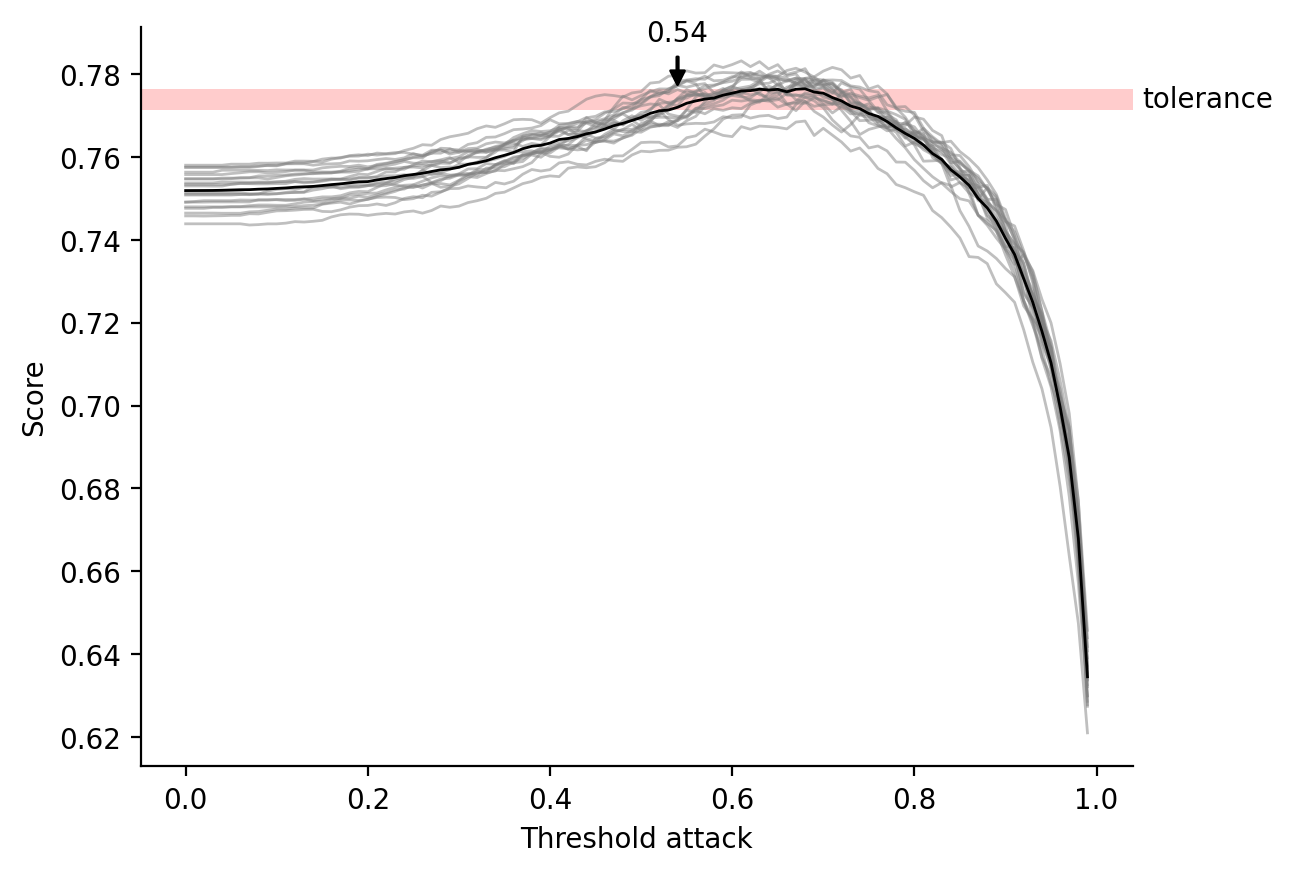

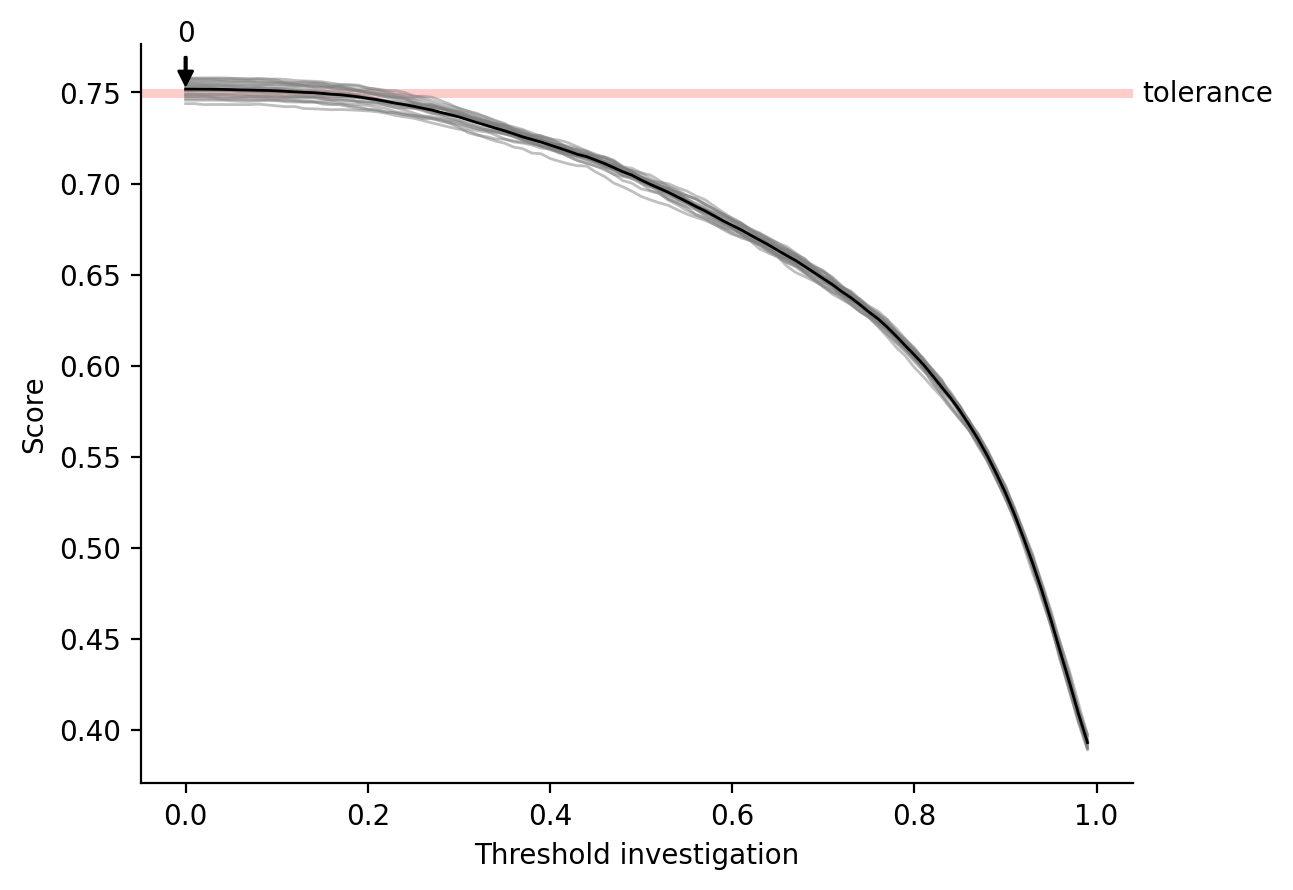

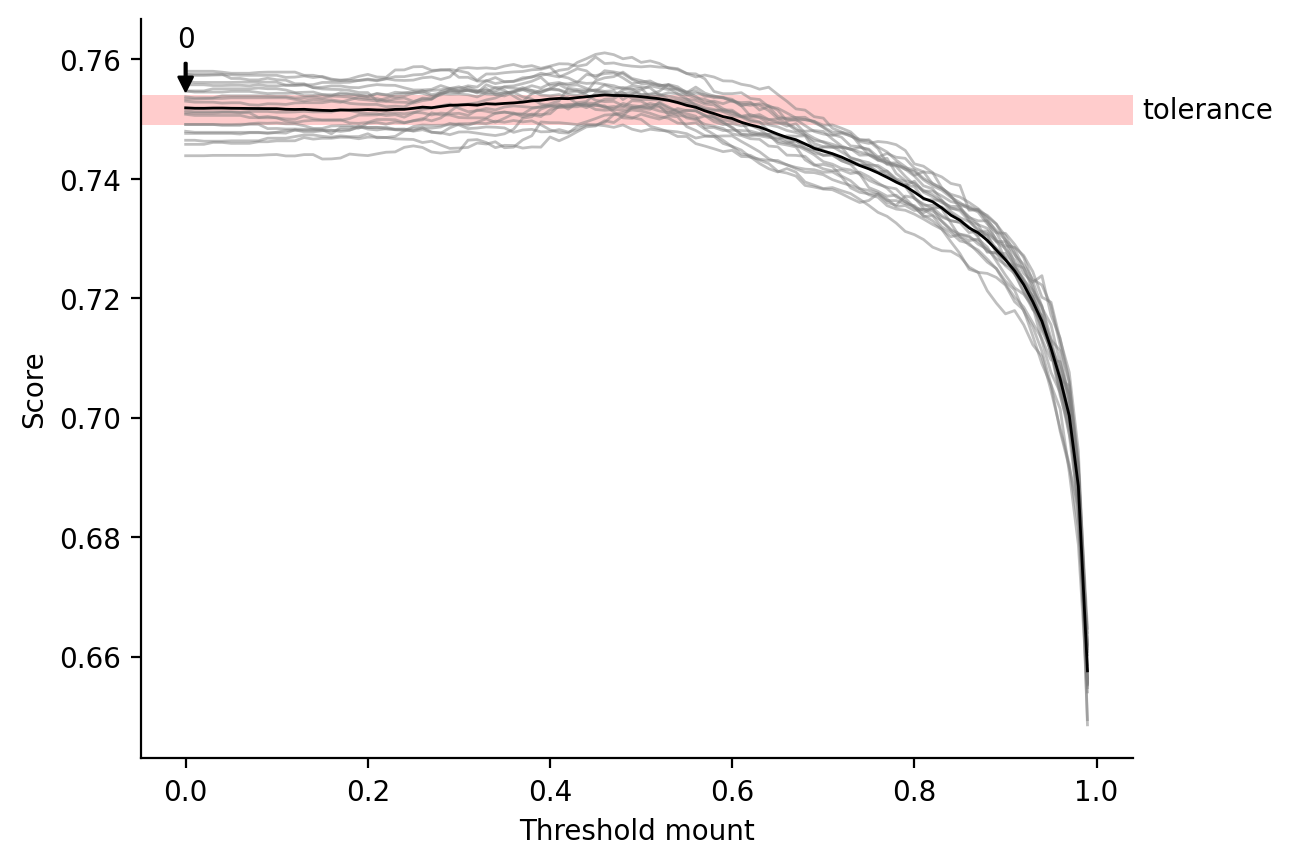

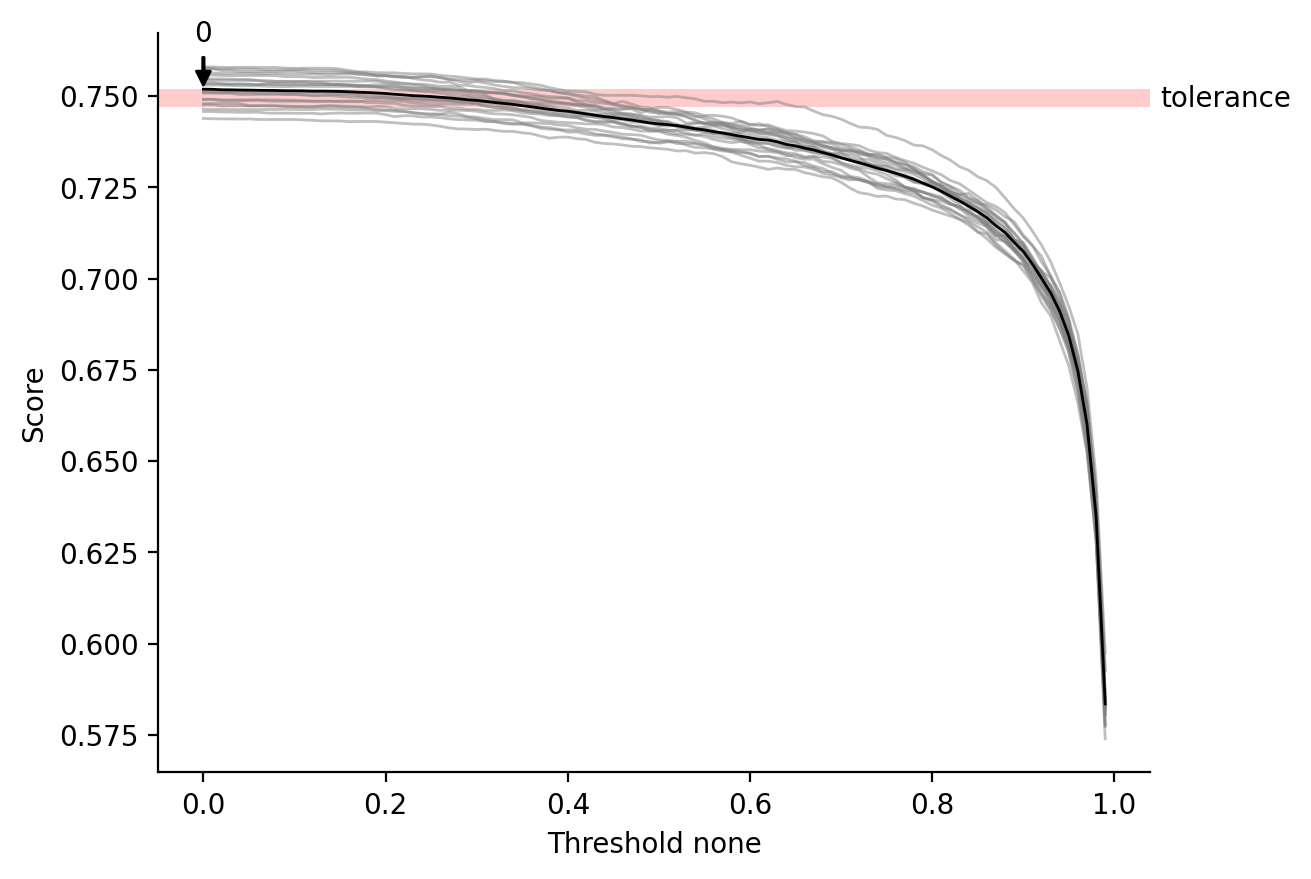

({'threshold_attack': 0.54},
 {'threshold_investigation': 0.0},
 {'threshold_mount': 0.0},
 {'threshold_none': 0.0})

In [8]:
best_thresholds = optimize_decision_thresholds(
    dataset_train,
    extractor,
    XGBClassifier,
    smoothing_func=lambda probabilities: medfilt(probabilities, int(best_parameters["median_filter_window"])),
    num_iterations=20,
    show_progress=True,
    k=5,
    exclude=[("intruder", "resident")],
    sampling_func=subsample_train,
    show_k_fold_progress=False,
    decision_threshold_range=(0.0, 1.0),
    decision_threshold_step=0.01,
    tolerance=0.005,
    plot_results=True,
    random_state=ensure_generator(1),
)

best_thresholds

In [10]:
from automated_scoring.classification.predict import k_fold_predict

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
k_fold_result = k_fold_predict(
    dataset_train,
    extractor,
    XGBClassifier,
    k=5,
    exclude=[("intruder", "resident")],
    random_state=ensure_generator(1),
    sampling_func=subsample_train,
    show_progress=True,
)

In [12]:
k_fold_result.classification_results.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

In [11]:
# category_labels = ['att', 'inv', 'mnt', 'none']

In [75]:
# 16 seems systematically shifted, maybe 41,

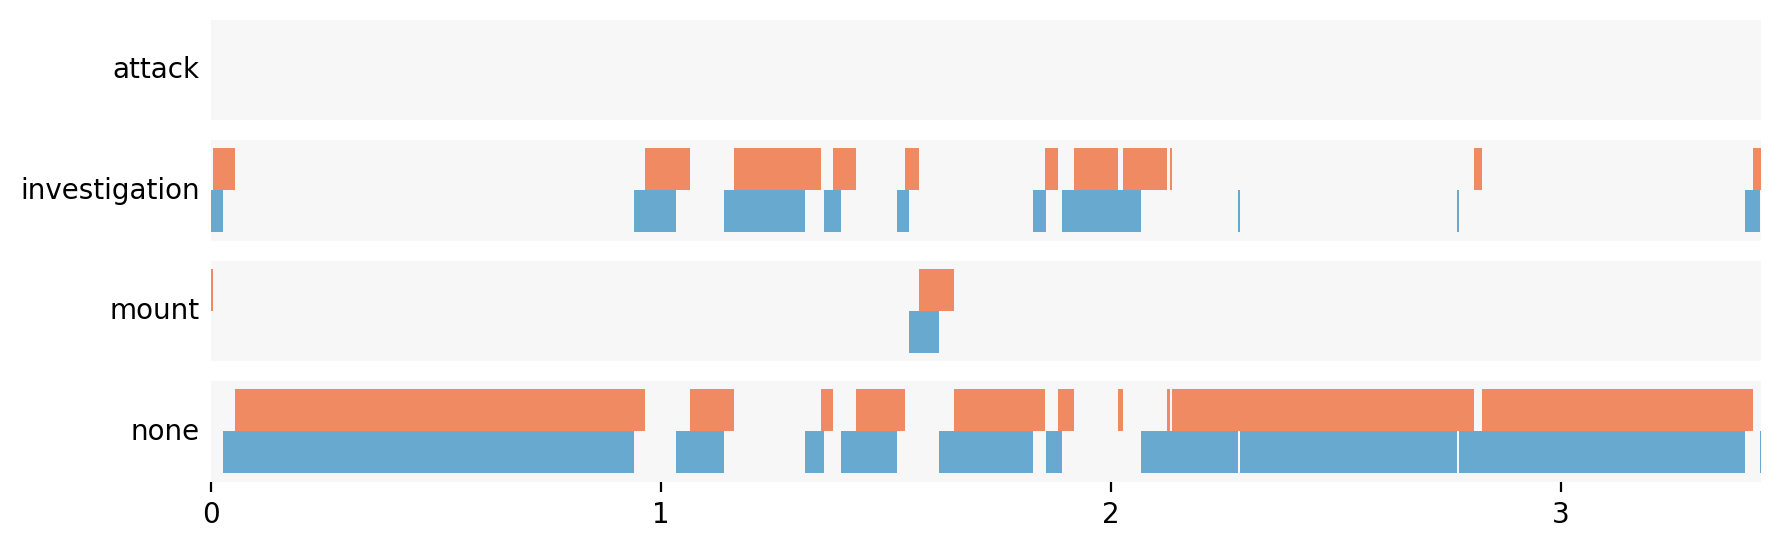

In [27]:
classification_results = k_fold_result.classification_results[16].classification_results[('resident', 'intruder')]

plot_classification_timeline(
    classification_results.predictions,
    classification_results.categories,
    annotations=classification_results.annotations,
    timestamps=classification_results.timestamps,
    interval=(-np.inf, np.inf),
    # y_proba=classification_results.y_proba,
    # y_proba_smoothed=classification_results.y_proba_smoothed,
    x_tick_step=(60 * 30),
    x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
)

In [17]:
f1_timestamp_raw = k_fold_result.f1_score("timestamp", encode_func=dataset_train.encode)
f1_annotation_raw = k_fold_result.f1_score("annotation", encode_func=dataset_train.encode)
f1_prediction_raw = k_fold_result.f1_score("prediction", encode_func=dataset_train.encode)

k_fold_result = k_fold_result.smooth([lambda probabilities: medfilt(probabilities, 41)])

f1_timestamp_smooth = k_fold_result.f1_score("timestamp", encode_func=dataset_train.encode)
f1_annotation_smooth = k_fold_result.f1_score("annotation", encode_func=dataset_train.encode)
f1_prediction_smooth = k_fold_result.f1_score("prediction", encode_func=dataset_train.encode)

k_fold_result = k_fold_result.threshold([0.54, 0, 0, 0])

f1_timestamp_thresh = k_fold_result.f1_score("timestamp", encode_func=dataset_train.encode)
f1_annotation_thresh = k_fold_result.f1_score("annotation", encode_func=dataset_train.encode)
f1_prediction_thresh = k_fold_result.f1_score("prediction", encode_func=dataset_train.encode)

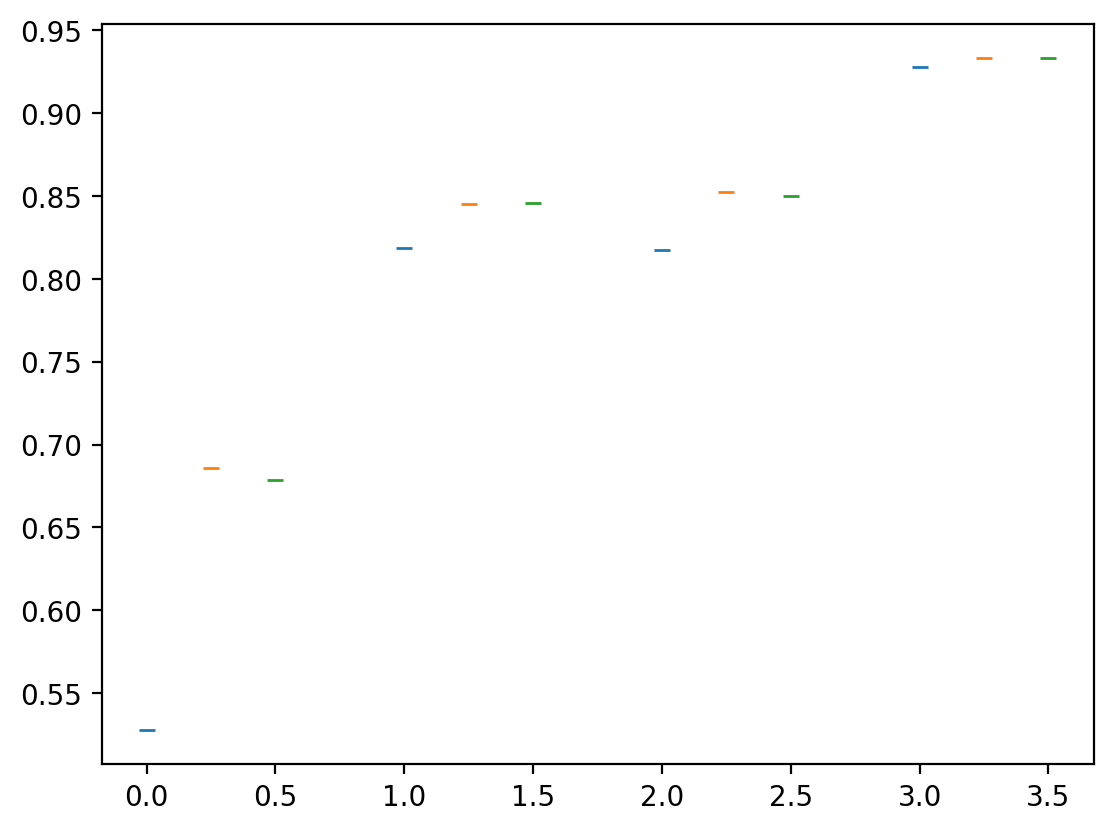

In [21]:
plt.plot(np.arange(4), f1_timestamp_raw, "_")
plt.plot(np.arange(4) + 0.25, f1_timestamp_smooth, "_")
plt.plot(np.arange(4) + 0.5, f1_timestamp_thresh, "_")

In [25]:
(
    f1_timestamp_raw[[0, 1, 2]].mean(),
    f1_timestamp_smooth[[0, 1, 2]].mean(),
    f1_timestamp_thresh[[0, 1, 2]].mean(),
)

(np.float64(0.721192208368404),
 np.float64(0.7944993749976305),
 np.float64(0.7914441904440194))

In [26]:
(
    f1_timestamp_raw.mean(),
    f1_timestamp_smooth.mean(),
    f1_timestamp_thresh.mean(),
)

(np.float64(0.7728860465666887),
 np.float64(0.8291264437693985),
 np.float64(0.8269098092720311))

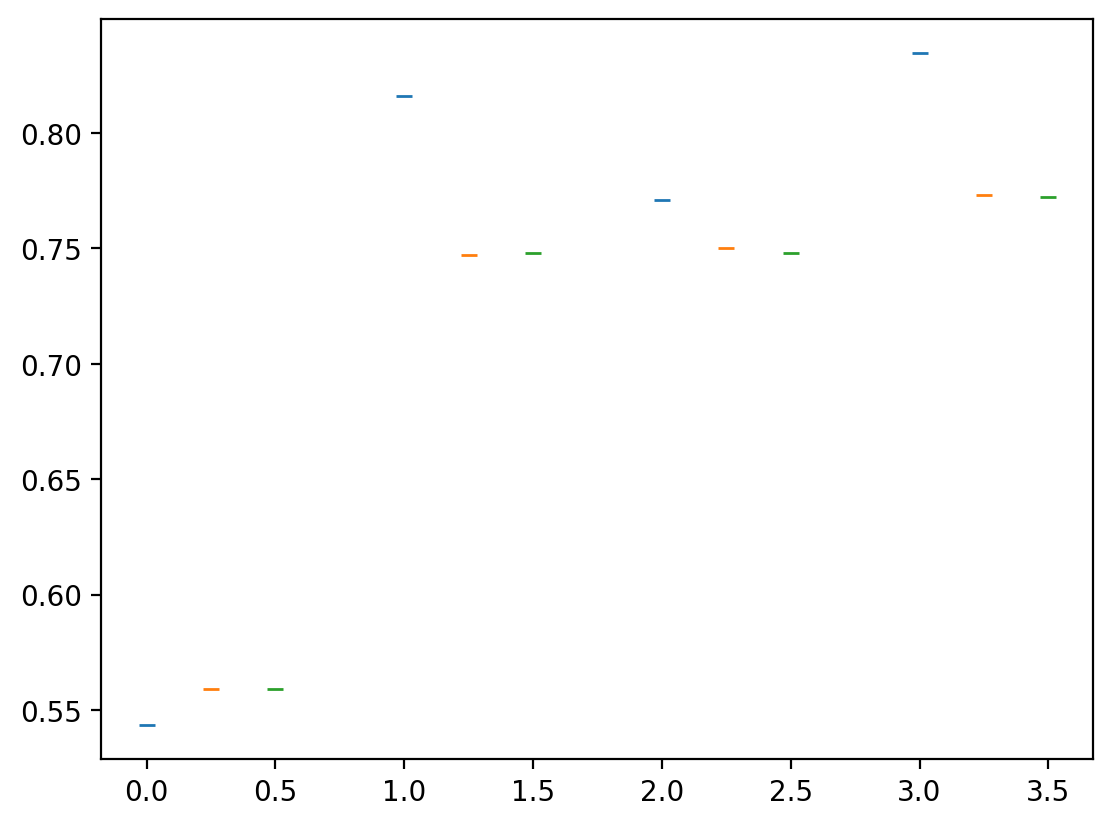

In [22]:
plt.plot(np.arange(4), f1_annotation_raw, "_")
plt.plot(np.arange(4) + 0.25, f1_annotation_smooth, "_")
plt.plot(np.arange(4) + 0.5, f1_annotation_thresh, "_")

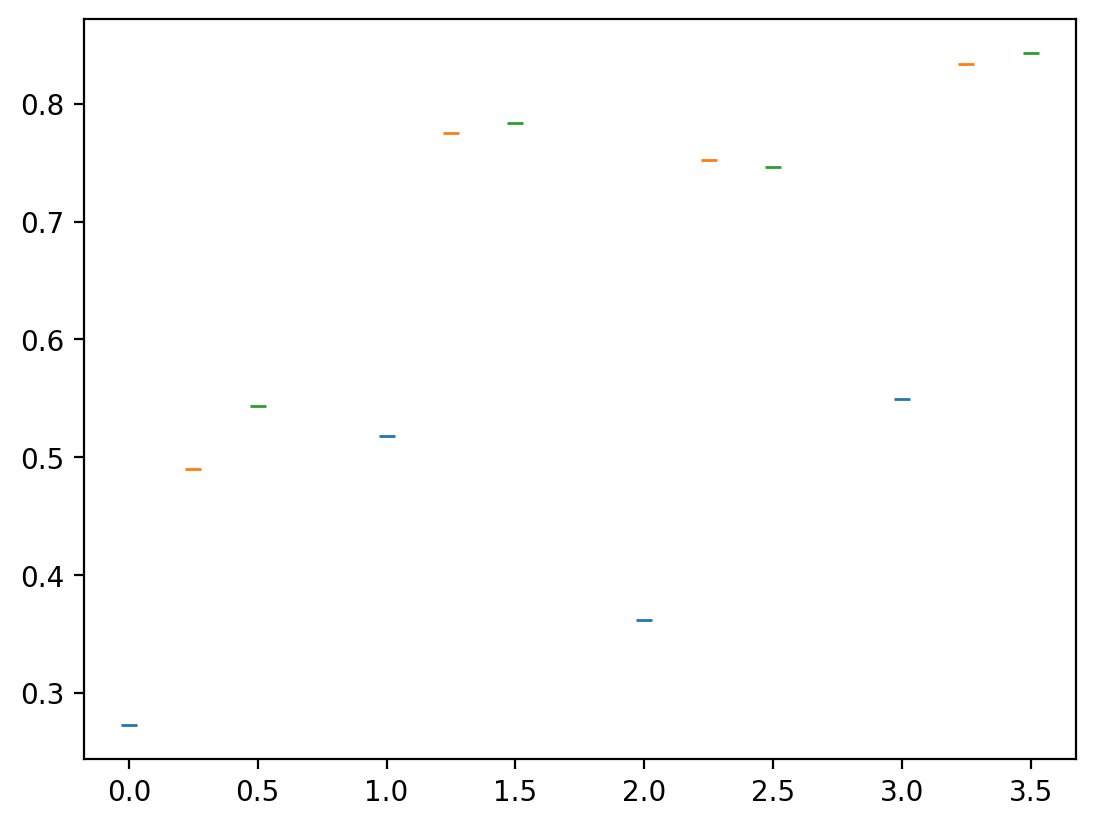

In [23]:
plt.plot(np.arange(4), f1_prediction_raw, "_")
plt.plot(np.arange(4) + 0.25, f1_prediction_smooth, "_")
plt.plot(np.arange(4) + 0.5, f1_prediction_thresh, "_")

In [29]:
from automated_scoring.classification.utils import to_prediction_dataset

In [34]:
dataset_k_fold = to_prediction_dataset(k_fold_result)

In [35]:
save_dataset(dataset_k_fold, directory="datasets", dataset_name="mice_predictions", observation_type="predictions")

In [37]:
from automated_scoring.io import load_dataset

dataset_predictions = load_dataset(directory="datasets", target="dyads", dataset_name="mice_predictions", observation_type="predictions")

Loading categories (attack, investigation, mount, none) from observations file, specify categories argument if incomplete.


In [40]:
from observation_library import ObservationLibrary
from glob import glob
import json

annotations = dataset_predictions.get_observations(exclude=[("intruder", "resident")])

video_files = sorted(glob("/home/paul/Downloads/task1_videos_mp4/train/*.mp4"))
video_lookup = {idx: [video_file] for idx, video_file in enumerate(video_files)}
trajectory_lookup = {
    group: dataset_predictions.select(group).trajectories
    for group in (
        dataset_predictions.groups
        if isinstance(dataset_predictions.groups, dict)
        else range(len(dataset_predictions.groups))
    )
}

observation_library = ObservationLibrary(
    annotations,
    video_lookup=video_lookup,
    trajectory_lookup=trajectory_lookup,
    num_keypoints=7,
    filter_dependencies={
        "actor": ("group", ),
        "recipient": ("group", "actor"),
    },
    highlight_observations_mode="category",
    selected_observations_mode="dyad",
)

with open("render_settings.json", "r") as f:
    render_settings = json.load(f)
    for key in render_settings:
        setattr(observation_library.render_settings, key, render_settings[key])

observation_library

ObservationLibrary(children=[_TableDisplay(action_dialogs=[Dialog(actions=[Switch(class_='pa-0 pl-2 ma-0', hid…